<a href="https://colab.research.google.com/github/arnauldnzegha/deep2pde_Berg_Nystrom/blob/master/Berg_Nystrom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Berg&Nystrom 2019 paper

Paper link in Journal of Computational Physics: https://www.sciencedirect.com/science/article/pii/S0021999119300944

Arxiv link: https://arxiv.org/abs/1808.10788

There are some differences between the two papers (like the NN architecture used).



## Implementation of the interpolated version


In [0]:
import tensorflow as tf
from keras import backend as K 
from keras.models import Model
import math as M
import matplotlib.pyplot as plt
from keras.optimizers import SGD,Adadelta
from keras.layers import Dense, Input
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import scipy.io
from keras.regularizers import l1
from sklearn.neural_network import MLPRegressor
from random import shuffle
import time;

### Loading data to compute Burgers PDE

*** burgers_sine.mat*** : https://drive.google.com/file/d/1NOYWXhdm6i3zyU5nbcteS617lCDKyc7P/view?usp=sharing

Download the file on your local drive and then execute the following code to upload the data on colab.
The file contains a compiled matrix of data (what is the structure ?)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
BURGERS_DATA_FILE_ID='1NOYWXhdm6i3zyU5nbcteS617lCDKyc7P'
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
dataFile = drive.CreateFile({'id': BURGERS_DATA_FILE_ID})
dataFile.GetContentFile('burgers_sine.mat')

the **getBurgersData( test  )** function retrieves the data from the **burgers_solution.txt** file and puts it in an array [x_values,  time_values] and an array [U_value].
These datas in *** burgers_sine.mat file***  are generated by a solution of the burgers equation.

With $\alpha =\frac{1}{\pi} *10^{-2}$

In [0]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
files.upload()
def get_burgers_data_2(test=0.07,mix=1):
	u_sol=[]
	f = open("burgers_solution.txt", "r")
	for line in f:
		elts=line.split()
		u_sol.extend(elts)
	nb_x_t=100
	min_x = -1.0
	max_x = +1.0
	vx = np.linspace ( min_x, max_x, nb_x_t )
	u_sol=np.float32(u_sol).reshape(-1,1)
	min_t = 0.0
	max_t = 3.0 / np.pi
	vt = np.linspace ( min_t, max_t, nb_x_t )
	X, T =np.zeros([nb_x_t*nb_x_t]), np.zeros([nb_x_t*nb_x_t])
	X, T =np.zeros([100*100]), np.zeros([100*100])
	for i in range(0,100):
		for j in range(0, 100):
			X[100*i+j],T[100*i+j]=vx[i], vt[j]
	x_data=[[X[i],T[i]] for i in range(0,nb_x_t**2)]
	x_data=np.array(x_data).reshape(-1,2)
	n_train = int(len(u_sol)*(1-test))
	if(mix==1): x_data, u_sol= mix_data(x_data, u_sol)
	X_train, Y_train = x_data[:n_train],  u_sol[:n_train]
	X_test, Y_test = x_data[n_train:], u_sol[n_train:]
	return np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)

In [0]:
def get_square_data(test=0.07,mix=1):
    x=np.array([i for i in range(0,10000)])/10000
    t=np.array([i for i in range(0,10000)])/10000
    x,s=mix_data(x,x)
    t,s=mix_data(t,t)
    X=[[x[i],t[i]] for i in range(0,9999)]
    X_sol_star = np.hstack((t,x))
    #print(X)
    u_sol_star=[x[0]**2 + x[1]**2 for x in X]
    #if(mix==1): X_sol_star, u_sol_star= mix_data(X_sol_star, u_sol_star)
    n_train = int(len(u_sol_star)*(1-test))
    X_train, Y_train = X[:n_train],  u_sol_star[:n_train]
    X_test, Y_test = X[n_train:], u_sol_star[n_train:]
    return  np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)

The mixData shuffle xs in a random order. ys ?

In [0]:
def mix_data(xs,ys):
    xys=[]
    for i in range(0,len(xs)-1):
        xys.append((xs[i],ys[i]))
    shuffle(xys)
    x2,y2=[],[]
    for (x,y) in xys:
        x2.append(x)
        y2.append(y)
    return (np.array(x2), np.array(y2))

### Implementation of the first MLP

The first model is a neural network (a MLP) with **5 hidden** layers and **10 units by hidden** layers. The activation is hyperbolic tangent.
L1 regulation term is used during training

In [0]:
def berg_nystrom_model1():
    L1_PENALTY_TERM=0.01
    l1_Reg = l1(L1_PENALTY_TERM)
    input_data = Input(shape=(2,))
    hidden1 = Dense(10, activation='tanh', name='l1' ,kernel_regularizer=l1_Reg)(input_data)
    hidden2 = Dense(10, activation='tanh', name='l2' ,kernel_regularizer=l1_Reg)(hidden1)
    hidden3 = Dense(10, activation='tanh', name='l3' ,kernel_regularizer=l1_Reg)(hidden2)
    hidden4 = Dense(10, activation='tanh', name='l4' ,kernel_regularizer=l1_Reg)(hidden3)
    hidden5 = Dense(10, activation='tanh', name='l5' ,kernel_regularizer=l1_Reg)(hidden4)
    output = Dense(1, activation='linear', name='l6' ,kernel_regularizer=l1_Reg)(hidden5)
    model = Model(input_data, output)
    return model

In [0]:
def berg_nystrom_model2(nb_class=1):
    input_data = Input(shape=(3,))
    hidden1 = Dense(2, activation='tanh', name='l1')(input_data)
    hidden2 = Dense(2, activation='tanh', name='l2')(hidden1)
    output = Dense(nb_class, activation='linear', name='sort')(hidden2)
    model = Model(input_data, output)
    return model

In [0]:
def berg_nystrom_model2_linear(nb_class=1):
    input_data = Input(shape=(3,))
    output = Dense(nb_class, activation='linear', name='sort')(input_data)
    model = Model(input_data, output)
    return model

In [0]:
def berg_nystrom_model2_linear_k2(nb_class=1):
    input_data = Input(shape=(3,))
    output = Dense(nb_class, activation='linear', name='sort')(input_data)
    model = Model(input_data, output)
    return model

**dataTrainModelEDP(X,U)** 

take a liste(** [x_value , time_val]** and** [u_value],** )  

and return a liste   **([U_value, x derivative of U, second order x derivative of U]**  and **[time derivative of U named Ut]**)

In [0]:
def data_to_train_model2(X,U):
    X_der=np.zeros(len(X))
    T_der=np.zeros(len(X))
    X_der2=np.zeros(len(X))
    X_train=np.zeros([len(X),3])
    for i in range(0, len(X)):
        layer_outs = get_layer_outputs(X[i])
        X_train[i][0]=U[i]
        X_train[i][1]=partiel_derivative(-1,0,X[i],layer_outs,tanh_deriv)
        X_train[i][2]=partiel_derivative(-1,1,X[i],layer_outs,tanh_deriv)
        X_der2[i]=partiel_derivative(-1,0,X[i],layer_outs, tanh_deriv2)
        #print(str(X[i][1])+"##--##"+str(X_train[i][2]))
    return X_train, X_der2

In [0]:
def data_to_train_model2_2(modelX,X,U):
    X_der=np.zeros(len(X))
    T_der=np.zeros(len(X))
    X_der2=np.zeros(len(X))
    X_train=np.zeros([len(X),3])
    for i in range(0, len(X)):
        X_train[i][0]=U[i]
        X_train[i][1]=partiel_derivative_2(modelX,0,X[i])
        X_train[i][2]=partiel_derivative_2(modelX,0,X[i])
        X_der2[i]=(partiel_derivative_2(modelX,0,X[i]+0.00001)-partiel_derivative_2(modelX,0,X[i]))/0.00001
        #print(str(X[i][1])+"##--##"+str(X_train[i][2]))
    return X_train, X_der2

This code returne in a list the output of each layer after a prediction.

In [0]:
def get_layer_outputs(test_data):
    test_data=test_data.reshape(1,2,)
    ar=np.float32(test_data)
    test_data2=[[ar]]
    outputs = [layer.output for layer in model.layers[1:]]
    functors = [K.function([model.input, K.learning_phase()], [out]) for out in outputs] 
    layer_outs = [func([test_data, 1.]) for func in functors]
    return test_data2+layer_outs

**tanh_deriv** return the derivative of tanh. $$th' = (1-th^2)$$


**tanh_deriv2** return the second order derivative  $$th' ' =  -2(th - th^3)$$


In [0]:
def tanh_deriv(x):
    return(1-(M.tanh(x))**2)

def tanh_deriv2 (x):
    return(-2*(M.tanh(x) -(M.tanh(x))**3))

In [0]:
def partiel_derivative(layer, n_i, inputX, layer_outs, fct_deriv):
    nb_l=len(model.layers)
    if((layer)>(-1*nb_l)):
        ln=len(model.layers[layer].get_weights()[0][0])
        if((layer-1)>(-1*nb_l)):
            inp=len(model.layers[layer-1].get_weights()[0][0])
        else:
            inp=len(inputX)
        Lpartial=np.zeros(ln)
        LpartialN=partiel_derivative(layer-1 ,n_i, inputX,layer_outs, fct_deriv)
        chaine=0
        for n in range(0,ln):
            act=model.layers[layer].get_weights()[1][n]
            chaine=0
            for i in range(0,inp):
                W=model.layers[layer].get_weights()[0][i][n]
                act+=W*layer_outs[layer-1][0][0][i]
                chaine+=W*LpartialN[i]
            if (layer==-1):
                Lpartial[n]=chaine
            else:
                Lpartial[n] = fct_deriv(act)*chaine
        return Lpartial
    else:
        Lpartial=np.zeros(len(inputX))
        Lpartial[n_i]=1
        return Lpartial

In [0]:
def partiel_derivative_skl(layer, n_i, inputX, layer_outs, fct_deriv):
    nb_l=len(Berg_Nystrom_skl_model_1.coefs_)
    if((layer)>(-1*nb_l)):
        ln=len(Berg_Nystrom_skl_model_1.coefs_[layer][:,0])
        if((layer-1)>(-1*nb_l)):
            inp=len(model.layers[layer-1].get_weights()[0])
        else:
            inp=len(inputX)
        Lpartial=np.zeros(ln)
        LpartialN=partiel_derivative(layer-1 ,n_i, inputX,layer_outs, fct_deriv)
        chaine=0
        for n in range(0,ln):
            act=model.layers[layer].get_weights()[1][:,n]
            chaine=0
            for i in range(0,inp):
                W=model.layers[layer].get_weights()[0][i][:,n]
                act+=W*layer_outs[layer-1][0][0][i]
                chaine+=W*LpartialN[i]
            if (layer==-1):
                Lpartial[n]=chaine
            else:
                Lpartial[n] = fct_deriv(act)*chaine
        return Lpartial
    else:
        Lpartial=np.zeros(len(inputX))
        Lpartial[n_i]=1
        return Lpartial

In [0]:
def partiel_derivative_2(modelX,n_i, inputX):
  inputX1=np.array([inputX])
  inputX1[n_i]=inputX1[n_i]+0.000001
  y1, y2= modelX.predict(inputX.reshape(1,2,)), modelX.predict(inputX1.reshape(1,2,))
  derv= (y2[0]-y1[0])/0.000001
  return derv

###Using Keras

The training phase 1 (1rst model) with SDG and the mean squared error.


In [0]:
X_train, Y_train, X_test, Y_test= get_burgers_data_2()

In [177]:
model = berg_nystrom_model1()
LEARNING_RATE,MOMENTUM,DECAY=0.01,0.9,1e-6
sgd = SGD(lr=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
#optim_results = tfp.optimizer.lbfgs_minimize( quadratic, initial_position=start, num_correction_pairs=10, tolerance=1e-8)
model.compile(loss='mean_squared_error', optimizer=sgd,  metrics=['accuracy'])

t= time.time()
hist=model.fit(X_train, Y_train, validation_split=0.15, batch_size=50, epochs=1000, verbose=0)
print("training time for  model (100 iterations) :"+str(time.time()-t))
print("cross validation mean error : "+str(hist.history["val_loss"][-1]))

training time for  model (100 iterations) :644.4429681301117
cross validation mean error : 0.17890616957645689


Gradients computation. 1rst order and 2nd order

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
grad_func = tf.gradients(model.output[:,0], model.input)
grad_func_second = tf.gradients(grad_func, model.input)
Uxt = sess.run(grad_func, feed_dict={model.input: X_train.reshape((-1, X_test[1].size))})[0]
Uxxtt = sess.run(grad_func_second, feed_dict={model.input: X_train.reshape((-1, X_test[1].size))})[0]
Ux_xx_train=[[X_train[i][0],Uxt[i][0],Uxxtt[i][0]] for i in range(0,len(Uxt))]
Ut_train=[[Uxt[i][1]] for i in range(0,len(Uxt))]
Ux_xx_train, Ut_train=np.array(Ux_xx_train), np.array(Ut_train)
print(Ut_train)
print("-------------")
print(X_train)
print("-------------")
print(Y_train)

The training phase1 (2nd model) with SDG and the mean squared error.

In [179]:
model2 = berg_nystrom_model2()
model2.compile(loss='mean_squared_error', optimizer=sgd,  metrics=['accuracy'])
t= time.time()
#X_train, Y_train, X_test, Y_test= get_burgers_data_2()
#X_train2, Y_train2=X_train[:300, :], Y_train[:300,]
#Uxx, Ut=data_to_train_model2(X_train2, Y_train2)
t2= time.time()
print("Partial derivatives computation time (50 derivative) :"+str(t2-t))
hist=model2.fit(Ux_xx_train, Ut_train, validation_split=0.1, batch_size=500, epochs=2000, verbose=0)
print("training time for  model (100 iterations) :"+str(time.time()-t2))
#print("cross validation mean error : "+str(hist.history["val_loss"][-1]))

Partial derivatives computation time (50 derivative) :1.811981201171875e-05
training time for  model (100 iterations) :101.31483769416809


In [154]:
model2_linear = berg_nystrom_model2_linear()
model2_linear.compile(loss='mean_squared_error', optimizer=sgd,  metrics=['accuracy'])
t= time.time()
hist=model2_linear.fit(Ux_xx_train, Ut_train, validation_split=0.1, batch_size=50, epochs=2000, verbose=0)
print("training time for  model (100 iterations) :"+str(time.time()-t))

training time for  model (100 iterations) :791.6421501636505


Test of prédiction of the model trained using keras

I just the prediction to see if it is close to u_val.


In [180]:
#X_train, Y_train, X_test, Y_test= get_burgers_data_2()
y_pred = model.predict(X_test)
print("Prediction of 1st Model && U(x,t)")
for i in range(0,5):
  print(str(y_pred[i])+" && " +str(Y_test[i]))

print(" ")

y_pred2 = model2.predict(Ux_xx_train[:10, :])
print("Prediction of 2nd Model && U_t,")
for i in range(0,5):
  print(str(y_pred2[i])+" && " +str(Ut_train[i]))

print(" ")

y_pred3 = model2_linear.predict(Ux_xx_train[:10, :])
print("Prediction of 2nd Model linear && U_t,")
for i in range(0,5):
  print(str(y_pred3[i])+" && " +str(Ut_train[i]))

Prediction of 1st Model && U(x,t)
[0.108721] && [0.198996]
[0.4887313] && [0.569988]
[0.3917535] && [0.309611]
[-0.5242994] && [-0.62857]
[-0.6488479] && [-0.483511]
 
Prediction of 2nd Model && U_t,
[0.5777677] && [0.56916785]
[0.38966668] && [0.388359]
[0.8864609] && [0.9259329]
[1.015756] && [0.9934623]
[1.1128973] && [1.1266155]
 
Prediction of 2nd Model linear && U_t,
[0.49723503] && [0.56916785]
[0.40814295] && [0.388359]
[0.7996401] && [0.9259329]
[0.9136801] && [0.9934623]
[1.1327826] && [1.1266155]


In [167]:
for i in range(0,3):
  print(model2.layers[-3+i].get_weights()[0][0])

[0.3913877 0.5314901]
[-0.5014231   0.94413483]
[0.11260688]


###Using SKlearn



create models 1 and 2

In [0]:
from sklearn.neural_network import MLPRegressor

Berg_Nystrom_skl_model_1 = MLPRegressor(solver='lbfgs',activation='tanh', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 10, 10), random_state=1, max_iter=1000)

Berg_Nystrom_skl_model_2 = MLPRegressor(solver='lbfgs',activation='tanh', alpha=1e-5, hidden_layer_sizes=(50,50,50,50), random_state=1, max_iter=1000)

In [0]:
X_train, Y_train, X_test, Y_test= get_burgers_data_2()
for i in range(0, 100):
  Berg_Nystrom_skl_model_1.fit(X_train, Y_train)
#print(Berg_Nystrom_skl_model_2.coefs_[0][:,0])

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d

In [0]:
Uxx, Ut=data_to_train_model2_2(Berg_Nystrom_skl_model_1,X_train, Y_train)

In [0]:
for i in range(0, 100):
  Berg_Nystrom_skl_model_2.fit(Uxx, Ut)

In [0]:
y_p = Berg_Nystrom_skl_model_2.predict(Uxx[:9])
print(y_p)
print(Ut[:9])

[ 14.50681752  14.50681752 -31.12226425 -31.12226425 -31.12226425
 -31.12226425  14.50681752 -31.12226425 -31.12226425]
[ 1.78846937e+01  1.41314516e+01 -1.61326508e+00  3.65245612e+00
 -2.05651052e+00 -3.87427126e+03  5.08941778e+00 -8.53154214e+00
 -4.77951012e+00]


Train the model using Sklearn

In [0]:
X_train, Y_train, X_test, Y_test= get_burgers_data_2()
model1_SKL = MLPRegressor(solver='lbfgs',activation='tanh', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 10, 10), random_state=1, max_iter=1000)
for i in range(0, 100):
  model1_SKL.fit(X_train, Y_train)

Test the model trained using sklearn

In [0]:
X_train, Y_train, X_test, Y_test= get_burgers_data_2(mix=0)
U=Y_test
#y_pred = model1_SKL.predict(X_train[1:])
print("Prediction of 1st Model && U(x,t) trained with sklearn")
for i in range(0,7):
  y_p = model1_SKL.predict(np.array(X_test[i]).reshape(1,2,))
  y=partiel_derivativeX(model1_SKL,0,X_test[i])
  print(str(X_test[i][0])+" &"+str(X_test[i][1])+"    ==  "+str(y_p[0])+" && " +str(U[i])+" dev "+str(y))
y_p = model1_SKL.predict(X_test)
for i in range(0,5):
  print(str(y_p[i])+" && " +str(U[i]))

Prediction of 1st Model && U(x,t) trained with sklearn
[-0.39609123]||[-0.396089]
0.8787878787878789 &0.0    ==  -0.3960912336584304 && [-0.371662] dev 2.2341963947791754
[-0.38933704]||[-0.38933484]
0.8787878787878789 &0.009645754126781536    ==  -0.3893370412623195 && [-0.361368] dev 2.2010053586929423
[-0.38269401]||[-0.38269185]
0.8787878787878789 &0.019291508253563072    ==  -0.3826940130400681 && [-0.351595] dev 2.167813585141065
[-0.37616202]||[-0.37615989]
0.8787878787878789 &0.02893726238034461    ==  -0.3761620235779398 && [-0.34231] dev 2.1346658243270866
[-0.36974081]||[-0.36973871]
0.8787878787878789 &0.038583016507126144    ==  -0.36974081195334935 && [-0.33348] dev 2.1016039318810797
[-0.36342999]||[-0.36342792]
0.8787878787878789 &0.04822877063390768    ==  -0.36342999098599416 && [-0.325074] dev 2.0686669304215144
[-0.35722906]||[-0.35722702]
0.8787878787878789 &0.05787452476068922    ==  -0.35722905627899215 && [-0.317064] dev 2.035891079221752
-0.3960912336584305 && 

Visualisation

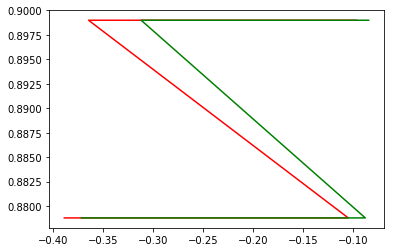

In [0]:
X_test3=X_test[:2000,:1].reshape(-1)
y_pred2=y_p[:2000].reshape(-1)
plt.plot(y_pred2, X_test3, 'r')


y_pred2=U[:2000].reshape(-1)
plt.plot(y_pred2, X_test3,'g')

In [0]:
def get_activations(clf, test_input):
        test_input=test_input.reshape(1,2,)
        hidden_layer_sizes = clf.hidden_layer_sizes
        if not hasattr(hidden_layer_sizes, "__iter__"):
            hidden_layer_sizes = [hidden_layer_sizes]
        hidden_layer_sizes = list(hidden_layer_sizes)
        layer_units = [test_input.shape[1]] + hidden_layer_sizes + \
            [clf.n_outputs_]
        activations = [test_input]
        for i in range(clf.n_layers_ - 1):
            activations.append(np.empty((test_input.shape[0],
                                         layer_units[i + 1])))
        clf._forward_pass(activations)
        activations=[x[0] for x in activations]
        return activations